In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
header = ['crim', 'zn', 'indus', 'riverside', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat', 'medv']
feature = header[:-1]
target = header[-1]

data_url = "https://raw.githubusercontent.com/punyaphatsura/Study/refs/heads/main/4-1/DataMining/Assignment03/housePrice_data.csv"
# houseData = pd.read_csv('./housePrice_data.csv', names=['header'])
houseData = pd.read_csv(data_url, names=['header'])
df = pd.DataFrame(columns=header)
for i in range(len(houseData)):
    df = pd.concat([df, pd.DataFrame([[float(i) for i in houseData.iloc[i].values[0].split()]], columns=header)], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   crim       506 non-null    float64
 1   zn         506 non-null    float64
 2   indus      506 non-null    float64
 3   riverside  506 non-null    float64
 4   nox        506 non-null    float64
 5   rm         506 non-null    float64
 6   age        506 non-null    float64
 7   dis        506 non-null    float64
 8   rad        506 non-null    float64
 9   tax        506 non-null    float64
 10  ptratio    506 non-null    float64
 11  black      506 non-null    float64
 12  lstat      506 non-null    float64
 13  medv       506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [3]:
from sklearn.model_selection import train_test_split

X = df[feature]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
def build_model(hp):
    model = keras.Sequential([
        # Input layer
        keras.layers.Input(shape=(X_train.shape[1],)),
        
        # Hidden layer with tunable units and ReLU activation
        keras.layers.Dense(
            units=hp.Int('units', min_value=32, max_value=512, step=32),
            activation='relu'
        ),
        
        # Output layer
        keras.layers.Dense(1)
    ])
    
    # Compile with tunable learning rate
    learning_rate = hp.Float(
        'learning_rate', 
        min_value=1e-4, 
        max_value=1e-2, 
        sampling='log'
    )
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

In [6]:
tuner = kt.Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=100,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='house_price_prediction'
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [7]:
tuner.search(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[stop_early]
)

Trial 254 Complete [00h 00m 03s]
val_mae: 2.9346632957458496

Best val_mae So Far: 2.642302989959717
Total elapsed time: 00h 04m 48s


In [8]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model
history = best_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[stop_early]
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 502.9067 - mae: 20.2722 - val_loss: 137.7014 - val_mae: 9.7312
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.7228 - mae: 8.5618 - val_loss: 76.6089 - val_mae: 7.0779
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.7284 - mae: 5.9068 - val_loss: 33.0244 - val_mae: 4.1978
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.4432 - mae: 4.1025 - val_loss: 28.7479 - val_mae: 3.9729
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.0422 - mae: 3.4203 - val_loss: 29.1178 - val_mae: 3.9834
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.6591 - mae: 3.1371 - val_loss: 24.9415 - val_mae: 3.4384
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.2895 - mae: 2.6784 - val_loss: 27.5379 - val_mae: 3.5127
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.3563 - mae: 2.7028 - val_loss: 23.6347 - val_mae: 3.2241
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

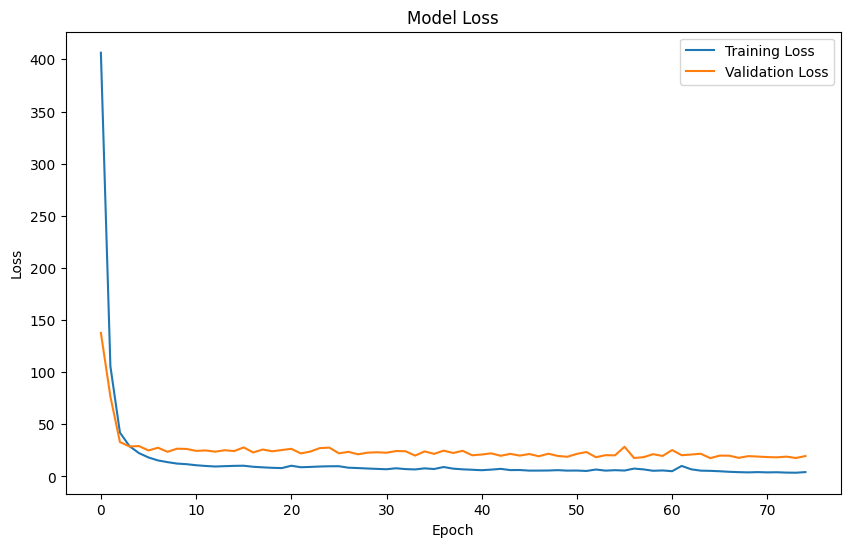

In [9]:
# Plot training & validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [10]:
# 7. Model Evaluation
y_pred = best_model.predict(X_test_scaled).flatten()

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Best Hyperparameters:")
print(f"Hidden Layer Units: {best_hps.get('units')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Optimized Epochs: {len(history.history['loss'])}")
print("\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Best Hyperparameters:
Hidden Layer Units: 384
Learning Rate: 0.009534114815412765
Optimized Epochs: 75

Model Performance:
Mean Absolute Error (MAE): 2.2181286961424584
Mean Squared Error (MSE): 7.794060560749432
Root Mean Squared Error (RMSE): 2.7917844760563866
